In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import shap
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import shap

In [22]:
data = pd.read_csv('Cleaned_full_data.csv')

C:\Users\adi_s\AppData\Local\Temp\ipykernel_15448\2584280520.py:1: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Cleaned_full_data.csv')


In [23]:
# Reset retained index.
data = data.reset_index(drop=True)
# Set NA to 0.
data['ct_ftp_cmd'] = data['ct_ftp_cmd'].fillna(0)
data['attack_cat'] = data['attack_cat'].str.replace(r'\s+', '', regex=True)
data['attack_cat'] = data['attack_cat'].str.replace('Backdoors', 'Backdoor')

In [24]:
data = data.drop(columns=['proto', 'dsport', 'service', 'state', 'srcip', 'sport', 'dstip'])

In [25]:
temp = data[['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat']]
data = data.drop(columns=['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat'])

In [26]:
ohe1 = pd.read_csv('Full_proto_encoded.csv')
ohe2 = pd.read_csv('Full_dsport_encoded.csv')
ohe3 = pd.read_csv('Full_service_encoded.csv')
ohe4 = pd.read_csv('Full_state_encoded.csv')
# Spelling error.
ohe5 = pd.read_csv('Full_scrip_encoded.csv')
#------------------------------------------#
ohe6 = pd.read_csv('Full_sport_encoded.csv')
ohe7 = pd.read_csv('Full_dstip_encoded.csv')

In [ ]:
# MinMax seperates Normal data well and reduces noise. Please see Kmeans TSNE evaluation in Archive.
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
data = pd.DataFrame(scaled_data, columns=data.columns)
data = pd.concat([data, temp, ohe1, ohe2, ohe3, ohe4, ohe5, ohe6, ohe7], axis=1)

In [88]:
X_train, X_test, y_train, y_test = train_test_split(data, data['label'], test_size=0.2, random_state=42)
# Drop attack cat before running model and store for later evaluation indexing.
test_attack_cat = X_test['attack_cat']
X_train = X_train.drop(columns=['attack_cat', 'label'])
X_test = X_test.drop(columns=['attack_cat', 'label'])
# Check label distribution.
print(data['attack_cat'].value_counts())

attack_cat
Normal            2218764
Generic            215481
Exploits            44525
Fuzzers             24246
DoS                 16353
Reconnaissance      13987
Analysis             2677
Backdoor             2329
Shellcode            1511
Worms                 174
Name: count, dtype: int64


In [97]:
# Run RandomForest with default settings.
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- attack_cat
- correct_predictions
- incorrect_predictions
- predicted_label
- true_label


In [ ]:
# Add labels back to the data and create a label list.
X_test['predicted_label'] = y_pred
X_test['true_label'] = y_test.values
X_test['attack_cat'] = test_attack_cat
X_test = X_test.reset_index(drop=True)
attack_categories = X_test['attack_cat'].unique()
# Iterate for each category label and group evaluation results and print.
for category in attack_categories:
    print(f"Evaluation for attack category: {category}")
    category_data = X_test[X_test['attack_cat'] == category]
    y_true_category = category_data['true_label']
    y_pred_category = category_data['predicted_label']
    correct_predictions = (y_true_category == y_pred_category).sum()
    total_samples = len(y_true_category)
    accuracy = accuracy_score(y_true_category, y_pred_category)
    precision = precision_score(y_true_category, y_pred_category, zero_division=0)
    recall = recall_score(y_true_category, y_pred_category, zero_division=0)
    f1 = f1_score(y_true_category, y_pred_category, zero_division=0)
    print(f"Total samples: {total_samples}")
    print(f"Correct predictions: {correct_predictions}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    print("\nClassification Report:\n", classification_report(y_true_category, y_pred_category, zero_division=0))
    print("-" * 50)

Evaluation for attack category: Normal
Total samples: 443831
Correct predictions: 443151
Accuracy: 0.9984678852986835
Precision: 0.0
Recall: 0.0
F1-Score: 0.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    443831
           1       0.00      0.00      0.00         0

    accuracy                           1.00    443831
   macro avg       0.50      0.50      0.50    443831
weighted avg       1.00      1.00      1.00    443831

--------------------------------------------------
Evaluation for attack category: Generic
Total samples: 43110
Correct predictions: 43108
Accuracy: 0.9999536070517281
Precision: 1.0
Recall: 0.9999536070517281
F1-Score: 0.9999768029877751

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      1.00      1.00     43110

    accuracy                           1.00     43110
   macr

In [91]:
# Get correct and incorrect predictions. Create DataFrames then drop the columns.
X_test['incorrect_predictions'] = X_test['predicted_label'] != X_test['true_label']
X_test['correct_predictions'] = X_test['predicted_label'] == X_test['true_label']
incorrect_predictions = X_test[X_test['incorrect_predictions'] == True]
correct_predictions = X_test[X_test['correct_predictions'] == True]
sdata1 = incorrect_predictions.reset_index(drop=True).drop(columns=['correct_predictions', 'incorrect_predictions', 'predicted_label'])
sdata2 = correct_predictions.reset_index(drop=True).drop(columns=['correct_predictions', 'incorrect_predictions', 'predicted_label'])
# Validate.
print("Incorrect Predictions (All):")
print(len(sdata1))
print("Correct Predictions (All):")
print(len(sdata2))

Incorrect Predictions (All):
1588
Correct Predictions (All):
506422


In [ ]:
sdata1 = sdata1[sdata1['attack_cat']=='DoS']
sdata2 = sdata2[sdata2['attack_cat']=='DoS']
sdata1 = sdata1.drop(columns=['attack_cat'])
sdata2 = sdata2.drop(columns=['attack_cat'])
dos_correct = sdata2[sdata2['true_label'] == 1]
dos_correct = dos_correct.drop(columns=['true_label'])
dos_incorrect = sdata1[sdata1['true_label'] == 1]
dos_incorrect = dos_incorrect.drop(columns=['true_label'])
print(len(dos_correct))
print(len(dos_incorrect))
dos_correct = dos_correct.sample(n=1000, random_state=42)
# Calculate shap for DoS rows.
# Incorrect Predictions.
explainer = shap.TreeExplainer(rf)
shap_values1 = explainer.shap_values(dos_incorrect)
# Verify shape.
print(shap_values1.shape)
print(dos_correct.shape)
# Correct Predictions.
explainer = shap.TreeExplainer(rf)
shap_values2 = explainer.shap_values(dos_correct)
# Verify shape.
print(shap_values2.shape)
print(dos_incorrect.shape)

3312
3
(3, 322, 2)
(1000, 322)
(1000, 322, 2)
(3, 322)


In [ ]:
sdata1.to_csv('sdata1_incorrect_DoS.csv')
sdata2.to_csv('sdata2_correct_DoS.csv')
shap_values1.to_csv('shap_values_incorrect_DoS.csv')
shap_values2.to_csv('shap_values2_correct_DoS.csv')

In [92]:
print(X_test.shape)
print(y_test.shape)

(508010, 327)
(508010,)


In [ ]:
X_shap = X_test.copy()
X_shap = X_shap.drop(columns=['predicted_label', 'true_label', 'attack_cat', 'incorrect_predictions', 'correct_predictions'])

In [ ]:
print(X_shap.head())

508010


In [98]:
X_shap = X_test.copy()

In [100]:
X_shap['label'] = y_test.values

In [101]:
print(X_shap['label'].value_counts(dropna=False))

label
0    443831
1     64179
Name: count, dtype: int64


In [102]:
X_shap = X_shap.sample(n=1000)

In [103]:
print(X_shap['label'].value_counts(dropna=False))

label
0    870
1    130
Name: count, dtype: int64


In [ ]:
X_shap.to_csv('1000SampleWithLabel-DashboardDoS.csv')

In [ ]:

from explainerdashboard import ExplainerDashboard, ClassifierExplainer
# Create and run dashboard with improvements
xp = ClassifierExplainer(rf, X_shap.drop(columns=['label']), X_shap['label'])

Detected RandomForestClassifier model: Changing class type to RandomForestClassifierExplainer...
Generating self.shap_explainer = shap.TreeExplainer(model)


In [107]:
dashboard = ExplainerDashboard(
    explainer, 
    mode='inline')
# Save the dashboard as HTML
dashboard.save_html("UNSW-NB-15_RandomForestDoSExtended.html")

Building ExplainerDashboard..


ValueError: The TreeExplainer was generated with a version of explainerdashboard<0.3 and therefore not compatible with this version of ExplainerDashboard due to breaking changes in between major versions! Please rebuild your TreeExplainer with this version, or downgrade back to explainerdashboard==0.2.20.1!

Correct Predictions


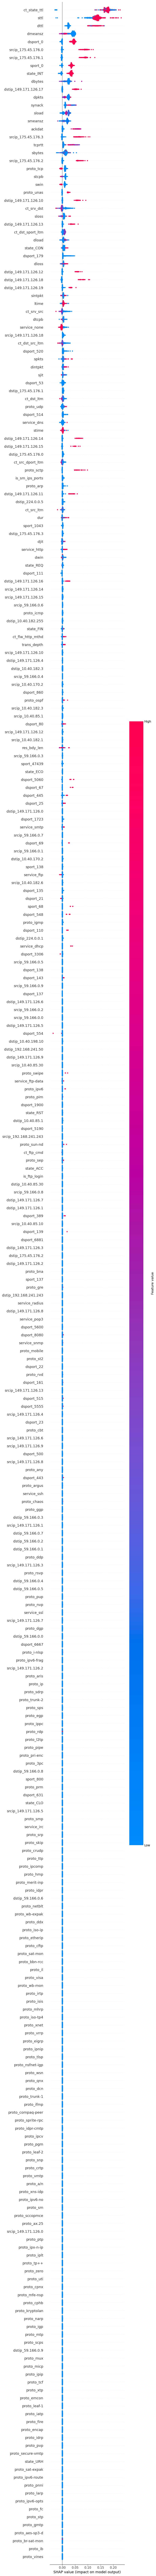

Incorrect Predictions


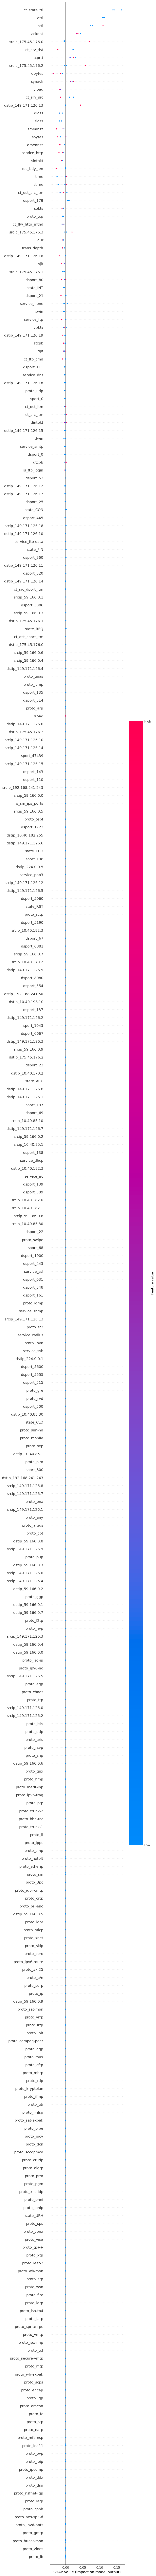

In [34]:
print('Correct Predictions')
shap.summary_plot(shap_values2[:, :, 1], dos_correct, max_display=len(dos_correct.columns), show=True)
print('Incorrect Predictions')
shap.summary_plot(shap_values1[:, :, 1], dos_incorrect, max_display=len(dos_incorrect.columns), show=True)